In [141]:
# checking files in my project's directory
#import os
#for dirname, _, filenames in os.walk('/home/pops/DataScience/my_projects/kaggle/House_Prices'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Preprocessing

In [142]:
# This is to supress the warning messages (if any) generated in our code
import warnings
warnings.filterwarnings('ignore')

# Import of fundamental libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as sts
%matplotlib inline

In [143]:
train = pd.read_csv('train.csv',index_col=0)
test = pd.read_csv('test.csv',index_col=0)

# Concatenating train and test datasets.
# They can be split again later on using the id columns as reference
full_data = pd.concat([train,test],axis=0)

print(f'Train dataset: {train.shape[0]} rows and {train.shape[1]} columns')
print(f'Test dataset:  {test.shape[0]} rows and {test.shape[1]} columns')
print(f'full_data dataset:  {full_data.shape[0]} rows and {full_data.shape[1]} columns')

Train dataset: 1460 rows and 80 columns
Test dataset:  1459 rows and 79 columns
full_data dataset:  2919 rows and 80 columns


In [144]:
# A huge mix of categorical (nominal and ordinal) with numerical (discrete and continuos) features.
# We will split them and apply some EDA seperately
from sklearn.compose import make_column_selector as selector

#####################
# All numerical features
####################
num_cols = selector(dtype_exclude=['object','category'])
num_cols = num_cols(train)
num_cols.remove('MSSubClass')
num_cols.remove('SalePrice')

####################################
# Numerical features: Discrete (disc)
####################################
disc = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

################################
# Numerical features: Continuous
###############################
cont = []
for i in num_cols:
    if i not in disc:
        cont.append(i)

######################
# All categorical features
#####################
cat_cols = selector(dtype_include=['object','category'])
cat_cols = cat_cols(train)
cat_cols = cat_cols + ['MSSubClass']

#################
# Ordinal 
#################
ordi = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond','PoolQC', 'Fence']

# Nominal
nomi = []
for i in cat_cols:
    if i not in ordi:
        nomi.append(i)

## Low correlation features

Removing all features with correlation lower than 0.1

In [145]:
num_cols_S = num_cols + ['SalePrice']
correlation = train[num_cols_S].corr()
c1 = correlation[['SalePrice']].sort_values(['SalePrice'],ascending=False)

In [146]:
c1[c1['SalePrice']<0.1]

,SalePrice
PoolArea,0.092404
MoSold,0.046432
3SsnPorch,0.044584
BsmtFinSF2,-0.011378
BsmtHalfBath,-0.016844
MiscVal,-0.021190
LowQualFinSF,-0.025606
YrSold,-0.028923
OverallCond,-0.077856
EnclosedPorch,-0.128578


In [147]:
lowcorr = list(c1[c1['SalePrice']<0.1].index)

In [148]:
lowcorr

['PoolArea',
 'MoSold',
 '3SsnPorch',
 'BsmtFinSF2',
 'BsmtHalfBath',
 'MiscVal',
 'LowQualFinSF',
 'YrSold',
 'OverallCond',
 'EnclosedPorch',
 'KitchenAbvGr']

In [149]:
full_data.drop(lowcorr, axis=1, inplace=True)

In [150]:
# removing from 'cont' list the features dropped
for i in lowcorr:
    if i in cont:
        cont.remove(i)

In [151]:
# removing from 'cont' list the features dropped
for i in lowcorr:
    if i in disc:
        disc.remove(i)

In [152]:
full_data.shape

(2919, 69)

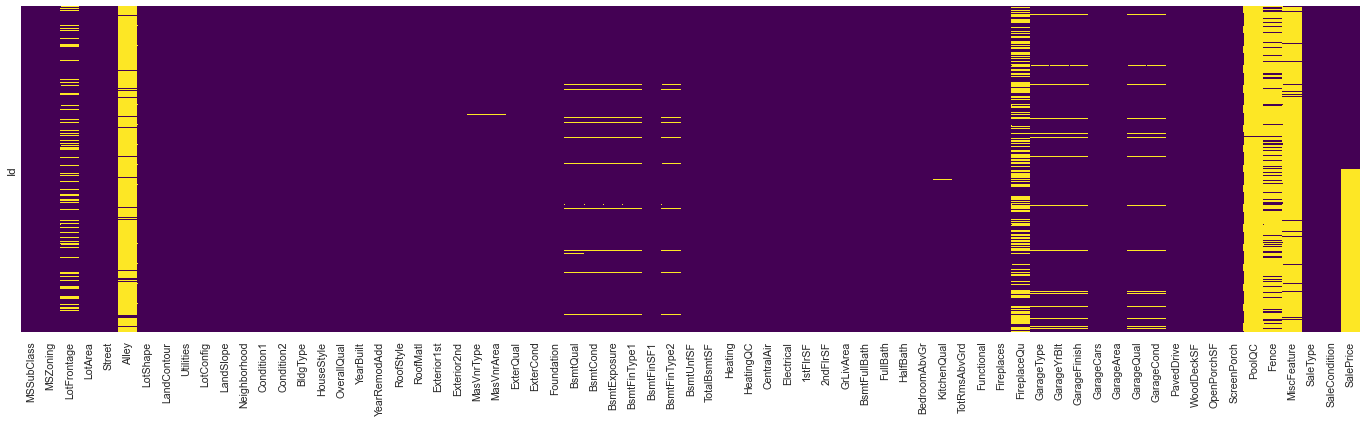

In [153]:
plt.figure(figsize=(24,6))
sns.heatmap(full_data.isnull(),
            yticklabels=False,
            cbar=False,
            cmap='viridis');

In [154]:
def missing_value(df):
    number = df.isnull().sum().sort_values(ascending=False)
    number = number[number > 0]
    percentage = df.isnull().sum() *100 / df.shape[0]
    percentage = percentage[percentage > 0].sort_values(ascending=False)
    return  pd.concat([number,percentage],keys=["Total","Percentage"],axis=1)

In [155]:
missing_value(full_data)

,Total,Percentage
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
SalePrice,1459,49.982871
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageFinish,159,5.447071
GarageYrBlt,159,5.447071
GarageCond,159,5.447071


In [156]:
## Features with more than 90% of values missing:
## PoolQC, MiscFeature, Alley
### Droping PoolQC, MiscFeature and Alley
full_data.drop(['PoolQC','MiscFeature','Alley'],axis=1,inplace=True)

In [157]:
full_data.shape

(2919, 66)

In [158]:
ordi.remove('PoolQC')

In [159]:
nomi.remove('MiscFeature')
nomi.remove('Alley')

### Multicolinearity - numerical features

From the results of correlation matrix between numerical features and their correlation with the target features the following ones were removed:

In [160]:
full_data.drop(['GarageCars','GarageYrBlt','TotRmsAbvGrd','1stFlrSF'],axis=1,inplace=True)

In [161]:
disc.remove('TotRmsAbvGrd')
disc.remove('GarageCars')

In [162]:
cont.remove('1stFlrSF')
cont.remove('GarageYrBlt')

In [163]:
full_data.shape

(2919, 62)

### Missing values - continuous features

In [164]:
missing_value(full_data[cont])

,Total,Percentage
LotFrontage,486,16.649538
MasVnrArea,23,0.787941
BsmtFinSF1,1,0.034258
BsmtUnfSF,1,0.034258
TotalBsmtSF,1,0.034258
GarageArea,1,0.034258


In [165]:
# LotFrontage - missing values imputed using median of Neighborhood
full_data['LotFrontage'] = full_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [166]:
# MasVnrArea - missing values imputed using mode
full_data['MasVnrArea'] = full_data['MasVnrArea'].fillna(sts.mode(full_data['MasVnrArea']))

In [167]:
# GarageArea - missing values imputed using mean value
full_data['GarageArea'] = full_data['GarageArea'].fillna(full_data['GarageArea'].mean())

In [168]:
# BsmtFinSF1 - missing values imputed using mode value
full_data['BsmtFinSF1'] = full_data['BsmtFinSF1'].fillna(sts.mode(full_data['BsmtFinSF1']))

In [169]:
# BsmtUnfSF - missing values imputed using median value
full_data['BsmtUnfSF'] = full_data['BsmtUnfSF'].fillna(full_data['BsmtUnfSF'].median())

In [170]:
# TotalBsmtSF - missing values imputed using mean value
full_data['TotalBsmtSF'] = full_data['TotalBsmtSF'].fillna(full_data['TotalBsmtSF'].mean())

### Missing values - discrete features

In [171]:
missing_value(full_data[disc])

,Total,Percentage
BsmtFullBath,2,0.068517


In [172]:
# BsmtFullBath - missing values imputed using mode value
full_data['BsmtFullBath'] = full_data['BsmtFullBath'].fillna(sts.mode(full_data['BsmtFullBath']))

### Missing values - nominal features

In [173]:
missing_value(full_data[nomi])

,Total,Percentage
GarageFinish,159,5.447071
GarageType,157,5.378554
MasVnrType,24,0.822199
MSZoning,4,0.137033
Utilities,2,0.068517
Functional,2,0.068517
Exterior2nd,1,0.034258
SaleType,1,0.034258
Electrical,1,0.034258
Exterior1st,1,0.034258


In [174]:
lst = list(missing_value(full_data[nomi]).index)

In [175]:
full_data[lst] = full_data[lst].transform(lambda x : x.fillna(x.mode()[0]))

____

### Missing Values - ordinal variables

In [176]:
missing_value(full_data[ordi])

,Total,Percentage
Fence,2348,80.438506
FireplaceQu,1420,48.646797
GarageQual,159,5.447071
GarageCond,159,5.447071
BsmtCond,82,2.809181
BsmtExposure,82,2.809181
BsmtQual,81,2.774923
BsmtFinType2,80,2.740665
BsmtFinType1,79,2.706406
KitchenQual,1,0.034258


In [177]:
lst2 = list(missing_value(full_data[ordi]).index)

In [178]:
full_data[lst2] = full_data[lst2].fillna("NA")

### Categorical features with single classes

In [179]:
singlers_ordi = []
for i in ordi:
    counts = train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 > 90:
        singlers_ordi.append(i)

singlers_ordi = list(singlers_ordi)

In [180]:
singlers_ordi

['GarageCond']

In [181]:
pd.DataFrame({'count': train['GarageCond'].dropna().value_counts(), 
                  '%': train['GarageCond'].dropna().value_counts()/len(train)*100})

,count,%
TA,1326,90.821918
Fa,35,2.397260
Gd,9,0.616438
Po,7,0.479452
Ex,2,0.136986


In [182]:
train['GarageCond'].isnull().sum()

81

In [183]:
# Dropping GarageCond as 90% of its non NA values are in a single class
full_data.drop('GarageCond', axis=1, inplace=True)

In [184]:
full_data.shape

(2919, 61)

In [185]:
ordi.remove('GarageCond')

In [186]:
singlers_nomi = []
for i in nomi:
    counts = train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 > 95:
        singlers_nomi.append(i)

singlers_nomi = list(singlers_nomi)

In [187]:
singlers_nomi

['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']

In [188]:
pd.DataFrame({'count': train['Street'].value_counts(), 
                  '%': train['Street'].value_counts()/len(train)*100})

,count,%
Pave,1454,99.589041
Grvl,6,0.410959


In [189]:
pd.DataFrame({'count': train['Utilities'].value_counts(), 
                  '%': train['Utilities'].value_counts()/len(train)*100})

,count,%
AllPub,1459,99.931507
NoSeWa,1,0.068493


In [190]:
pd.DataFrame({'count': train['LandSlope'].value_counts(), 
                  '%': train['LandSlope'].value_counts()/len(train)*100})

,count,%
Gtl,1382,94.657534
Mod,65,4.452055
Sev,13,0.890411


In [191]:
pd.DataFrame({'count': train['Condition2'].value_counts(), 
                  '%': train['Condition2'].value_counts()/len(train)*100})

,count,%
Norm,1445,98.972603
Feedr,6,0.410959
RRNn,2,0.136986
PosN,2,0.136986
Artery,2,0.136986
RRAe,1,0.068493
RRAn,1,0.068493
PosA,1,0.068493


In [192]:
pd.DataFrame({'count': train['RoofMatl'].value_counts(), 
                  '%': train['RoofMatl'].value_counts()/len(train)*100})

,count,%
CompShg,1434,98.219178
Tar&Grv,11,0.753425
WdShngl,6,0.410959
WdShake,5,0.342466
ClyTile,1,0.068493
Membran,1,0.068493
Metal,1,0.068493
Roll,1,0.068493


In [193]:
pd.DataFrame({'count': train['Heating'].value_counts(), 
                  '%': train['Heating'].value_counts()/len(train)*100})

,count,%
GasA,1428,97.808219
GasW,18,1.232877
Grav,7,0.479452
Wall,4,0.273973
OthW,2,0.136986
Floor,1,0.068493


In [194]:
full_data.drop(singlers_nomi,axis=1,inplace=True)

In [195]:
full_data.shape

(2919, 56)

In [196]:
nomi.remove('Street')
nomi.remove('Utilities')
nomi.remove('Condition2')
nomi.remove('RoofMatl')
nomi.remove('Heating')

### Mapping ordinal features

In [197]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
ordmap = ['GarageQual', 'FireplaceQu', 'KitchenQual', 'HeatingQC', 'BsmtCond', 
          'BsmtQual', 'ExterCond', 'ExterQual']

for i in ordmap:
    full_data[i] = full_data[i].map(ordinal_map)

In [198]:
Bsmt_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
bsmtmap = ['BsmtFinType2', 'BsmtFinType1']

for i in bsmtmap:
    full_data[i] = full_data[i].map(Bsmt_map)

In [199]:
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
full_data['BsmtExposure'] = full_data['BsmtExposure'].map(expose_map)

In [200]:
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}
full_data['Fence'] = full_data['Fence'].map(fence_map) 

In [201]:
full_data.shape

(2919, 56)

### Target feature - SalePrice

Removing outliers from the target feature

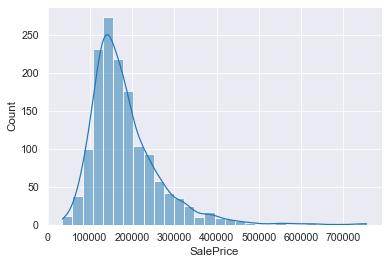

In [202]:
sns.set_context('paper',font_scale=1.2)
sns.set_style('darkgrid')
sns.histplot(x='SalePrice',data=full_data,bins=30,kde=True)
plt.show()

In [203]:
full_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [204]:
full_data[full_data['SalePrice'] > 500000]

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageArea,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,ScreenPorch,Fence,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
179,20,RL,63.0,17423,IR1,Lvl,CulDSac,Gtl,StoneBr,Norm,...,1166.0,3,Y,0,60,0,0,New,Partial,501837.0
441,20,RL,105.0,15431,Reg,Lvl,Inside,Gtl,NridgHt,Norm,...,672.0,3,Y,0,72,170,0,WD,Normal,555000.0
692,60,RL,104.0,21535,IR1,Lvl,Corner,Gtl,NoRidge,Norm,...,832.0,3,Y,382,50,0,0,WD,Normal,755000.0
770,60,RL,47.0,53504,IR2,HLS,CulDSac,Mod,StoneBr,Norm,...,841.0,3,Y,503,36,210,0,WD,Normal,538000.0
804,60,RL,107.0,13891,Reg,Lvl,Inside,Gtl,NridgHt,Norm,...,1020.0,3,Y,52,170,192,0,New,Partial,582933.0
899,20,RL,100.0,12919,IR1,Lvl,Inside,Gtl,NridgHt,Norm,...,820.0,3,Y,0,67,0,0,New,Partial,611657.0
1047,60,RL,85.0,16056,IR1,Lvl,Inside,Gtl,StoneBr,Norm,...,716.0,3,Y,214,108,0,0,New,Partial,556581.0
1170,60,RL,118.0,35760,IR1,Lvl,CulDSac,Gtl,NoRidge,Norm,...,807.0,3,Y,361,76,0,0,WD,Normal,625000.0
1183,60,RL,160.0,15623,IR1,Lvl,Corner,Gtl,NoRidge,Norm,...,813.0,3,Y,171,78,0,3,WD,Abnorml,745000.0


In [205]:
full_data = full_data.drop(full_data[full_data['SalePrice']>500000].index)

In [206]:
full_data[full_data['SalePrice'] > 500000]

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageArea,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,ScreenPorch,Fence,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,


Normalizing the distribution 

In [207]:
full_data["SalePrice"] = np.log(full_data['SalePrice'])

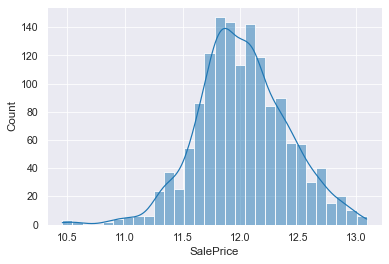

In [208]:
sns.set_context('paper',font_scale=1.2)
sns.set_style('darkgrid')
sns.histplot(x='SalePrice',data=full_data,bins=30,kde=True)
plt.show()

Generating numerical values for all variables in the full dataset

In [209]:
full_data = pd.get_dummies(full_data)
full_data.to_csv('full_data.csv',index=True)
print(f'full_data dataset: {full_data.shape[0]} rows and {full_data.shape[1]} columns')

full_data dataset: 2910 rows and 190 columns
